In [1]:
import os
from os.path import join as pjoin
from typing import List, Dict, Union
from random import choice, sample
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from PIL import UnidentifiedImageError
import piexif
from piexif import ImageIFD

## To check a single image

In [2]:
def search_not_rot_1(path: str) -> Dict:
    """
    To check the rotation number of images.
    return: a dictionary with the numbers of each image type, and all the arrays which store image names.
    """
    not_rot_1_imgs = []
    unidentified_imgs = []
    no_orient_info_imgs = []
    img_names = sorted([
        img_name for img_name in os.listdir(path) if img_name.endswith('.JPG') or img_name.endswith('.png')
    ])
    for img_name in img_names:
        img_path_name = pjoin(path, img_name)
        try: 
            image = Image.open(img_path_name)
            if 'exif' in image.info:
                exif_dict = piexif.load(image.info['exif'])
                if exif_dict['0th'][ImageIFD.Orientation] != 1:
                    not_rot_1_imgs.append(img_name)
    
        except UnidentifiedImageError:
#             print(f'cannot identify image file: {img_path_name}')
            unidentified_imgs.append(img_name)
            
        except KeyError:
#             print(f'There is no orientation info in {img_path_name}!')
            no_orient_info_imgs.append(img_name)
            
    not_rot = f'# not_rot_1: {len(not_rot_1_imgs)}'
    unidentified = f'# unidentified: {len(unidentified_imgs)}'
    no_orient_info = f'# no_orient_info: {len(no_orient_info_imgs)}'
    result_str = (not_rot, unidentified, no_orient_info)
    
    result_dict = {
        'result_str': result_str,
        'not_rot': not_rot_1_imgs,
        'unidentified': unidentified_imgs,
        'no_orient_info': no_orient_info_imgs
    }
    
    return result_dict


def get_exif_info(path: str, name: str) -> Union[int, str]:
    """
    To obtain the EXIF information of a image.
    """
    path_name = pjoin(path, name)
    image = Image.open(path_name)
    
    if 'exif' in image.info:
        exif_dict = piexif.load(image.info['exif'])
        img_orientation_key = ImageIFD.Orientation
        img_orientation = exif_dict['0th'][img_orientation_key]
        return image.info, img_orientation
    
    else:
        print(image.info)
        return f'There is no EXIF info in {path_name}!', None
    
    
def show_imgs(common_path: str, img_name: str):
    """
    To show a wrong-Bboxed image, and a corrected image.
    """
    f, ax = plt.subplots(1, 2, figsize=(15, 10))
    f.suptitle(f'img_name: {img_name}')
    f.tight_layout()
    
    old_ex_path = pjoin(common_path, 'img_211130')  # TODO need to change to prefer location
    new_ex_path = pjoin(common_path, 'img_211201')  # TODO need to change to prefer location
    old_img_path = pjoin(old_ex_path, img_name)
    new_img_path = pjoin(new_ex_path, img_name)
    
    ax[0].axis('off')
    ax[0].set_title('old')
    ax[0].imshow(Image.open(old_img_path))
    ax[1].axis('off')
    ax[1].set_title('new')
    ax[1].imshow(Image.open(new_img_path))
    
    plt.show()

In [3]:
raw_ex_path = pjoin('..', 'burn_raw_imgs')  # TODO need to change to prefer location
not_rot_imgs = search_not_rot_1(raw_ex_path)['not_rot']
# print(not_rot_imgs)

In [4]:
# example_img = '00005866.JPG'
example_img = choice(not_rot_imgs)
print(example_img)

In [5]:
del_rot_path = pjoin('..', 'before_crop_data', 'non_rot_images')  # TODO need to change to prefer location
print(f'raw orientation: {get_exif_info(raw_ex_path, example_img)[1]}')
print(f'modified orientation: {get_exif_info(del_rot_path, example_img)[1]}')

raw orientation: 6
modified orientation: 1


In [6]:
common_path = pjoin('..', 'record')  # TODO need to change to prefer location
old_ex_path = pjoin(common_path, 'img_211130')  # TODO need to change to prefer location
new_ex_path = pjoin(common_path, 'img_211201')  # TODO need to change to prefer location
print(f'old: {get_exif_info(old_ex_path, example_img)[1]}')
print(f'new: {get_exif_info(new_ex_path, example_img)[1]}')

{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
old: None
{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
new: None


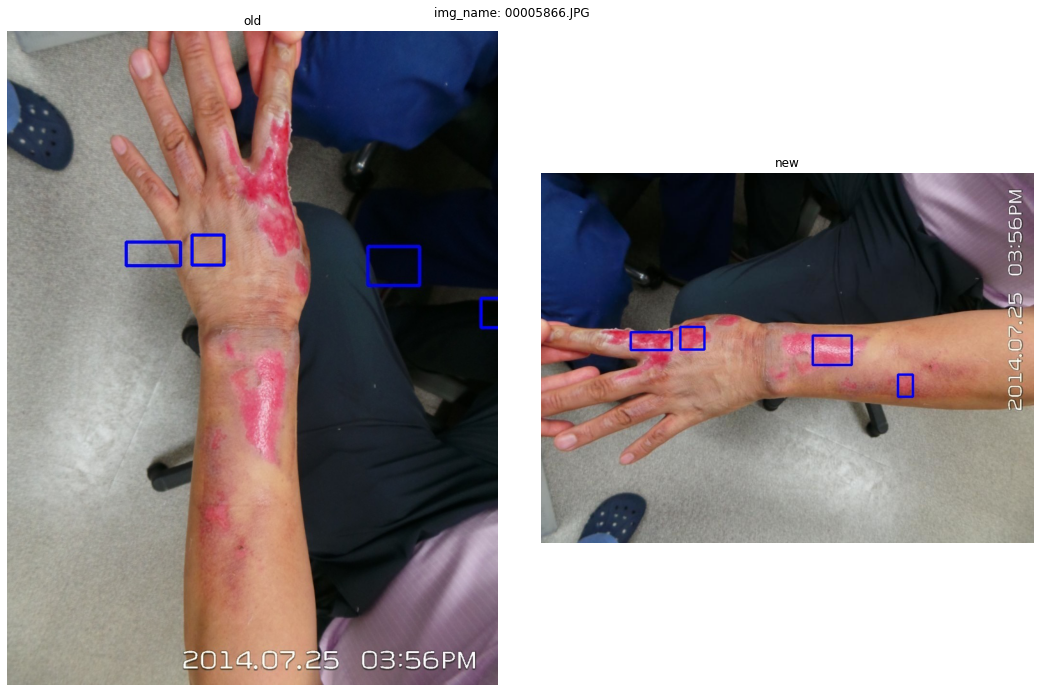

In [7]:
show_imgs(common_path, example_img)

## To turn the rotation of a image off

In [ ]:
def turn_off_exif_rotation(old_path: str, image_file_name: str, new_path: str) -> np.ndarray:
    """
    To set the rotation number to 1(non-rotation), and to save an image with the rotation number 1.
    """
    old_path_name = pjoin(old_path, image_file_name)
    new_path_name = pjoin(new_path, image_file_name)
    image = Image.open(old_path_name)
    
    if 'exif' in image.info:
        exif_dict = piexif.load(image.info['exif'])
        img_orientation = piexif.ImageIFD.Orientation
        if (img_orientation in exif_dict['0th']) and exif_dict['0th'][img_orientation] != 1:
            # print(f'{image_file_name}')
            # print(f"current rotation value: {exif_dict['0th'][img_orientation]}")
            exif_dict['0th'][img_orientation] = 1
            # print('rotation value is set to 1')
            
        exif_bytes = piexif.dump(exif_dict)
        image = image.convert('RGB')  # to remove `alpha` information from `RGBA`
        image.save(new_path_name, exif=exif_bytes)
        
    else:
        image = image.convert('RGB')  # to remove `alpha` information from `RGBA`
        image.save(new_path_name)
    
    return np.array(Image.open(new_path_name))


def turn_off_exif_rotation_in_dir(old_path: str, new_path: str, images_name_list: List) -> [List, ...]:
    """
    To set the rotation number to 1, several times.
    """
    non_rot_images = []
    non_recog_images_list = []
    for name in images_name_list:
        old_path_name = pjoin(old_path, name)
        if os.path.isfile(old_path_name):
            try:
                non_rot_image = turn_off_exif_rotation(old_path, name, new_path)
                non_rot_images.append(non_rot_image)
                
            except (UnidentifiedImageError, OSError):
                print(f'{name} is unidentified!')
                non_recog_images_list.append(name)
                
    print(f'The number of unidentified images: {len(non_recog_images_list)}')
                
#     return non_rot_images, non_recog_images_list

In [ ]:
# example
# old_path = pjoin('..', 'burn_raw_imgs')
# new_path = pjoin('..', 'before_crop_data', 'non_rot_images')
# images_name_list = sorted(os.listdir(old_path))
# images_name_list.remove('00002883.JPG')

In [ ]:
# turn_off_exif_rotation_in_dir(old_path, new_path, images_name_list)